In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed

import discretize 
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    Data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from simpeg.electromagnetics import time_domain as tdem
from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation #DaskMetaSimulation

In [2]:
# from inversions_1d import create_inversion, run_inv

In [3]:
Solver = get_default_solver()
Solver

pymatsolver.direct.pardiso.Pardiso

# load data 

In [4]:
n_times_invert = 20

In [5]:
rx_locs = np.load("rx_locs.npy")

In [6]:
def load_pre_file(filepath):
    """
    Load a GIF-style .pre file (TDoctree format).

    Parameters
    ----------
    filepath : str
        Path to the .pre-style data file

    Returns
    -------
    dict
        {
            "ignore": float or None,
            "n_trx": int,
            "transmitters": list of {
                "location": list of float,
                "n_recv": int,
                "n_time": int,
                "receivers": list of {
                    "loc": (x, y, z),
                    "time": float,
                    "data": list of float
                }
            }
        }
    """
    with open(filepath, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    i = 0
    ignore_value = None
    transmitters = []

    # Parse IGNORE line if present
    if lines[i].startswith("IGNORE"):
        ignore_value = float(lines[i].split()[1])
        i += 1

    # Parse number of transmitters
    if lines[i].startswith("N_TRX"):
        n_trx = int(lines[i].split()[1])
        i += 1
    else:
        raise ValueError("Missing N_TRX line")

    while i < len(lines):
        if lines[i].startswith("TRX_LOOP"):
            i += 1
            location = list(map(float, lines[i].split()))
            i += 1
            if not lines[i].startswith("N_RECV"):
                raise ValueError("Expected N_RECV")
            n_recv = int(lines[i].split()[1])
            i += 1
            if not lines[i].startswith("N_TIME"):
                raise ValueError("Expected N_TIME")
            n_time = int(lines[i].split()[1])
            i += 1

            receivers = []
            for _ in range(n_recv * n_time):
                parts = lines[i].split()
                x, y, z = map(float, parts[0:3])
                time = float(parts[3])
                data = list(map(float, parts[4:]))
                receivers.append({
                    "loc": (x, y, z),
                    "time": time,
                    "data": data
                })
                i += 1

            transmitters.append({
                "location": location,
                "n_recv": n_recv,
                "n_time": n_time,
                "receivers": receivers
            })
        else:
            i += 1  # Skip unknown or empty lines

    return {
        "ignore": ignore_value,
        "n_trx": len(transmitters),
        "transmitters": transmitters
    }


In [7]:
dobs = load_pre_file("dpred0.txt")

In [8]:
rx_times = np.array([dobs["transmitters"][0]["receivers"][j]["time"] for j in range(len(dobs["transmitters"][0]["receivers"]))])

In [9]:
rx_times

array([2.00000000e-05, 2.54854997e-05, 3.24755348e-05, 4.13827616e-05,
       5.27330180e-05, 6.71963657e-05, 8.56266480e-05, 1.09111896e-04,
       1.39038559e-04, 1.77173358e-04, 2.25767578e-04, 2.87689978e-04,
       3.66596142e-04, 4.67144294e-04, 5.95270288e-04, 7.58538038e-04,
       9.66586048e-04, 1.23169642e-03, 1.56951994e-03, 2.00000000e-03])

In [10]:
n_times_invert = len(rx_times)

# create survey

In [11]:
tx_height = rx_locs[0, 2]
source_list = []

for i in range(rx_locs.shape[0]): 
    rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
    src = tdem.sources.CircularLoop(
        receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    source_list.append(src)

full_survey = tdem.Survey(source_list)


In [12]:
dobs_values = np.zeros((n_times_invert, len(dobs["transmitters"])))
for i in range(len(dobs["transmitters"])): 
    for j in range(n_times_invert): 
        dobs_values[j, i] = dobs["transmitters"][i]["receivers"][j]["data"][-1]

In [13]:
observed_data = Data(survey=full_survey, dobs=-discretize.utils.mkvc(dobs_values))

In [14]:
ind = 25
rx_locs[ind, :]

array([-50.,   0.,  30.])

In [15]:
ubc_mesh = discretize.TreeMesh.read_UBC("octree_mesh.txt")
model = discretize.TreeMesh.read_model_UBC(ubc_mesh, "target_0.con")

In [16]:
len(full_survey.source_list)

61

In [17]:
src_ind = int((len(full_survey.source_list) -1 )/2)
src_ind

30

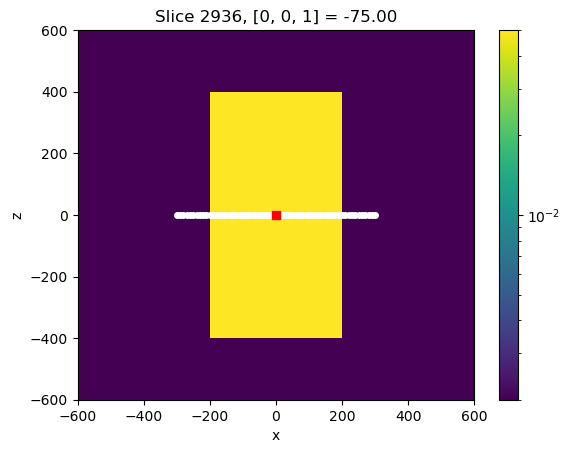

In [18]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(
    ubc_mesh.plot_slice(
        model, ax=ax, pcolor_opts={"norm":LogNorm()}, 
        normal="Z", ind=2936
    )[0], 
    ax=ax
)

ax.set_xlim(600*np.r_[-1, 1])
ax.set_ylim(600*np.r_[-1, 1])

ax.plot(rx_locs[:, 0], rx_locs[:, 1], "wo", ms=4)
ax.plot(rx_locs[src_ind, 0], rx_locs[src_ind, 1], "rs", ms=6)

In [19]:
observed_data[src, src.receiver_list[0]]

array([-1.364386e-07, -8.531943e-08, -5.259267e-08, -3.404938e-08,
       -2.190820e-08, -1.391419e-08, -8.741296e-09, -5.420790e-09,
       -3.219646e-09, -1.969642e-09, -1.159147e-09, -6.569660e-10,
       -3.595224e-10, -1.851239e-10, -9.813153e-11, -5.001906e-11,
       -2.472933e-11, -1.189668e-11, -6.141207e-12, -3.136186e-12])

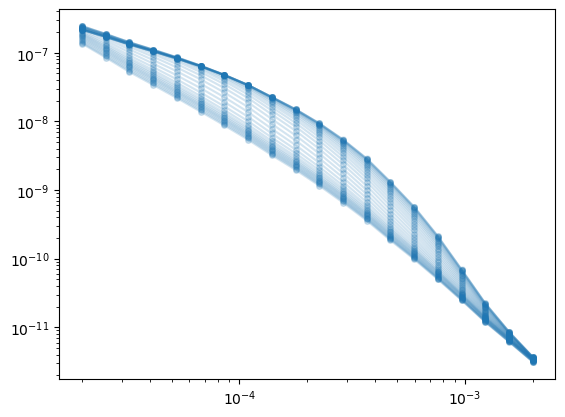

In [20]:
for src_ind in range(len(rx_locs)): 
    src = full_survey.source_list[src_ind]
    
    # plt.loglog(rx_times, -data_dict["background"][src, src.receiver_list[0]], "k", alpha=0.5)
    plt.loglog(rx_times, -observed_data[src, src.receiver_list[0]], "C0-o", ms=4, alpha=0.1)

In [21]:
# target_z_center = -60
# target_thickness = 40

thicknesses_true = np.r_[40, 40]
sigma_true = 1./np.r_[500, 20, 500]

In [22]:
src_ind = int(len(rx_locs)/2)
src_ind

30

In [23]:

source_sounding = full_survey.source_list[src_ind]
survey_sounding = tdem.Survey([source_sounding])
sim1d_true = tdem.Simulation1DLayered(
    survey=survey_sounding, thicknesses=thicknesses_true, sigmaMap=maps.IdentityMap(nP=3)
)

In [24]:
dpred_halfspace = sim1d_true.dpred(1./500*np.ones(3))

In [25]:
dpred_1d = sim1d_true.dpred(sigma_true)

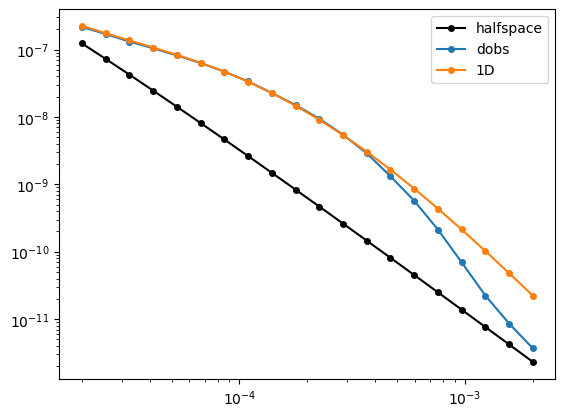

In [26]:
fig, ax = plt.subplots(1, 1)

ax.loglog(rx_times, -dpred_halfspace, "k-o", ms=4, label="halfspace")
ax.loglog(rx_times, -observed_data[source_sounding, source_sounding.receiver_list[0]], "C0-o", ms=4, label="dobs")
ax.loglog(rx_times, -dpred_1d, "C1-o", ms=4, label="1D")

ax.legend()

In [27]:
# octree_mesh = discretize.load_mesh("./synthetic-data/treemesh.json")

# octree_mesh = discretize.load_mesh()

In [479]:
cs = 10
core_region = 200
npad = 12
padding_factor = 1.3

thicknesses1d = discretize.utils.unpack_widths(
    [(cs, np.int64(np.ceil(core_region/cs))), (cs, npad, padding_factor)]
)

In [480]:
np.sum(thicknesses1d)


np.float64(1166.2503553075103)

In [830]:
# set up 1D inversion 
def create_inversion(
    ind,
    dobs,
    rx_times_invert=rx_times[:n_times_invert],
    rx_locs=rx_locs, 
    relative_error=0.1,
    noise_floor=2e-11,
    alpha_s = 1e-2,
    alpha_x = 1,
    rho_back = 500,
    beta0 = 200,
): 
    cs = 10
    core_region = 200
    npad = 12
    padding_factor = 1.3
    
    thicknesses1d = discretize.utils.unpack_widths(
        [(cs, np.int64(np.ceil(core_region/cs))), (cs, npad, padding_factor)]
    )
    
    rx_sounding = tdem.receivers.PointMagneticFluxTimeDerivative(
        locations=rx_locs[ind, :], times=rx_times_invert, orientation="z"
    )
    src_sounding = tdem.sources.CircularLoop(
        receiver_list=[rx_sounding], location=rx_locs[ind, :], orientation="z", 
        radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    survey_sounding = tdem.Survey([src_sounding])
    mesh_invert = discretize.TensorMesh([(np.r_[thicknesses1d, thicknesses1d[-1]])], origin="0")
    
    sim1d = tdem.Simulation1DLayered(
        survey=survey_sounding, thicknesses=thicknesses1d, sigmaMap=maps.ExpMap(mesh_invert)
    )

    data_invert = Data(
        survey_sounding, 
        dobs=dobs,
        standard_deviation=relative_error*np.abs(dobs) + noise_floor
    )
    
    dmis = data_misfit.L2DataMisfit(simulation=sim1d, data=data_invert)
    reg = regularization.WeightedLeastSquares(
        mesh_invert, alpha_s=alpha_s, alpha_x=alpha_x, 
        # reference_model=np.log(1./rho_back),
        # norms=norms
    )
    
    opt = optimization.InexactGaussNewton(maxIter=20)
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt, beta=beta0)
    
    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
    
    cool_beta = directives.BetaSchedule(coolingFactor=1.5, coolingRate=1)
    
    # Update the preconditionner
    update_Jacobi = directives.UpdatePreconditioner()
    
    # Options for outputting recovered models and predicted data for each beta.
    save_iteration = directives.SaveOutputDictEveryIteration(
        saveOnDisk=False,
    )
    
    
    # Updating the preconditionner if it is model dependent.
    update_jacobi = directives.UpdatePreconditioner()
    
    # Add sensitivity weights
    sensitivity_weights = directives.UpdateSensitivityWeights()
    
    target_misfit = directives.TargetMisfit()
    
    # The directives are defined as a list.
    directives_list = [
        sensitivity_weights,
        update_jacobi,
        # starting_beta,
        cool_beta,
        save_iteration,
        target_misfit,
    ]
    
    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)
    return inv

In [831]:
len(rx_locs)

61

In [832]:
ind = 30
source_sounding = full_survey.source_list[ind]
inv = create_inversion(
    ind, observed_data[source_sounding, source_sounding.receiver_list[0]], 
    rx_times[:n_times_invert], rx_locs
)

In [833]:
rho_start = 500
m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)
mopt = inv.run(m0)


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e+02  1.02e+03  0.00e+00  1.02e+03    1.17e+02      0              
   1  1.33e+02  5.34e+02  6.33e-01  6.18e+02    9.36e+01      0              
   2  8.89e+01  3.54e+02  1.07e+00  4.49e+02    7.24e+01      1              
   3  5.93e+01  2.47e+02  1.53e+00  3.38e+02    1.02e+02      

In [834]:
iterations = len(inv.directiveList.dList[-2].outDict)

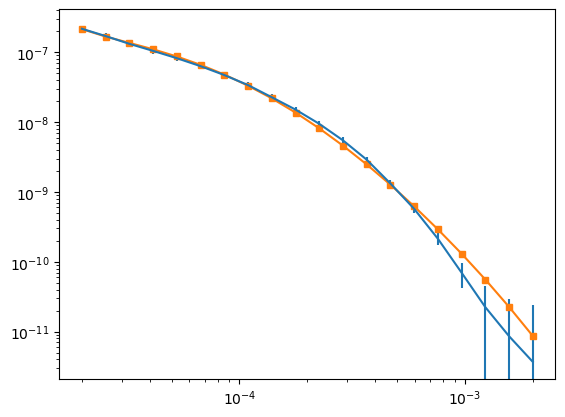

In [835]:

# plt.loglog(rx_times, -data_dict["background"][src, src.receiver_list[0]], "k", alpha=0.5)
# plt.loglog(rx_times, -data_dict[key][src, rx], "C0o", ms=4)
rx_times_invert = rx_times[:n_times_invert]
plt.errorbar(rx_times_invert, -inv.invProb.dmisfit[0][1].data.dobs, yerr=inv.invProb.dmisfit[0][1].data.standard_deviation)
plt.loglog(rx_times_invert, -inv.directiveList.dList[-2].outDict[iterations]["dpred"], "C1-s", ms=4)

(1e-05, 100.0)

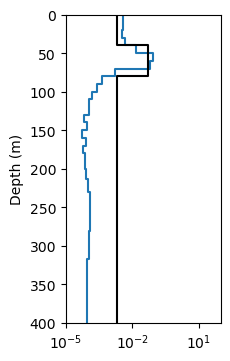

In [836]:
fig, ax = plt.subplots(1, 1, figsize=(2, 4))
plot_1d_layer_model(
    thicknesses1d, np.exp(mopt), ax=ax, color="C0", label="recovered"
)
plot_1d_layer_model(
    thicknesses_true, sigma_true, ax=ax, color="k", label="true"
)
ax.set_ylim([400, 0])
ax.set_xlim([1e-5, 1e2])


In [837]:

ind = 0
source_sounding = full_survey.source_list[ind]
inv = create_inversion(
    ind, observed_data[source_sounding, source_sounding.receiver_list[0]], rx_times[:n_times_invert], rx_locs
)

In [838]:
rho_start = 500
m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)
mopt = inv.run(m0)



Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e+02  2.15e+02  0.00e+00  2.15e+02    1.57e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.1597e+01
0 : |xc-x_last| = 3.6931e+00 <= tolX*(1+|x0|) = 3.6700e+00
0 : |proj(x-g)-x|    = 1.5695e+02 <= tolG   

(0.0001, 0.1)

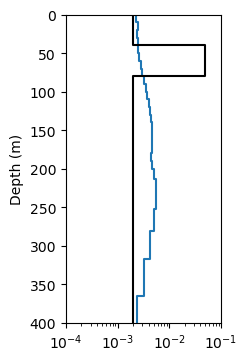

In [839]:
fig, ax = plt.subplots(1, 1, figsize=(2, 4))
plot_1d_layer_model(
    thicknesses1d, np.exp(mopt), ax=ax, color="C0", label="recovered"
)
plot_1d_layer_model(
    thicknesses_true, sigma_true, ax=ax, color="k", label="true"
)
ax.set_ylim([400, 0])
ax.set_xlim([1e-4, 1e-1])


In [840]:
rho_start = 500
m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)

In [841]:
directory = "/t40array/lheagy/2025-heagy-et-al-tle/dipping-layer-0"

In [842]:
def run_inv(ind, dobs, m0, directory=directory): 
    inv = create_inversion(ind, dobs)
    
    label_key=f"{ind}"
    
    mopt = inv.run(m0)
    np.save(f"{directory}/{label_key}_model.npy", mopt)
    
    inv_dict = inv.directiveList.dList[-2].outDict
    with open(f"{directory}/{label_key}_inv_dict.pkl", "wb") as f:
        pickle.dump(inv_dict, f)

    return label_key, mopt

In [843]:
ind=0
src = full_survey.source_list[ind]
rx = src.receiver_list[0]
run_inv(0, observed_data[src, rx], m0, directory)


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e+02  2.15e+02  0.00e+00  2.15e+02    1.57e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.1597e+01
0 : |xc-x_last| = 3.6931e+00 <= tolX*(1+|x0|) = 3.6700e+00
0 : |proj(x-g)-x|    = 1.5695e+02 <= tolG   

('0',
 array([-6.10314929, -6.00982878, -6.03447404, -6.01033082, -5.97684208,
        -5.93307696, -5.87840871, -5.81313621, -5.73922841, -5.66083826,
        -5.58399994, -5.51519429, -5.45939408, -5.41886127, -5.39335164,
        -5.38118307, -5.38025066, -5.38856373, -5.39768683, -5.36514956,
        -5.27025871, -5.17895516, -5.17464477, -5.26934541, -5.45422822,
        -5.71909345, -6.05791268, -6.45773968, -6.83827097, -6.98217049,
        -6.82324457, -6.57247256, -6.34770091]))

In [844]:
from joblib import Parallel, delayed
inv_dict = {}
results = Parallel(n_jobs=48, backend='loky')(  # 'loky' is the default and most flexible
    delayed(run_inv)(
        ind, observed_data[full_survey.source_list[ind], 
        full_survey.source_list[ind].receiver_list[0]], 
        m0, directory)
    for ind in range(rx_locs.shape[0])
)

# Collect results
for (label_key, mopt) in results:
    inv_dict[label_key] = mopt

In [845]:
def load_models_and_dicts(folder):
    inv_dicts = {}
    model_arrays = {}

    for fname in os.listdir(folder):
        full_path = os.path.join(folder, fname)

        if fname.endswith("_inv_dict.pkl"):
            key = fname.replace("_inv_dict.pkl", "")
            with open(full_path, "rb") as f:
                inv_dicts[key] = pickle.load(f)

        elif fname.endswith("_model.npy"):
            key = fname.replace("_model.npy", "")
            model_arrays[key] = np.load(full_path)

    return inv_dicts, model_arrays

In [846]:
inv_dicts, models_1d = load_models_and_dicts(directory)

In [847]:
mesh1d = discretize.TensorMesh([(np.r_[thicknesses1d, thicknesses1d[-1]])], origin="0")


In [848]:
mesh1d.cell_centers

array([   5.        ,   15.        ,   25.        ,   35.        ,
         45.        ,   55.        ,   65.        ,   75.        ,
         85.        ,   95.        ,  105.        ,  115.        ,
        125.        ,  135.        ,  145.        ,  155.        ,
        165.        ,  175.        ,  185.        ,  195.        ,
        206.5       ,  221.45      ,  240.885     ,  266.1505    ,
        298.99565   ,  341.694345  ,  397.2026485 ,  469.36344305,
        563.17247597,  685.12421875,  843.66148438, 1049.7599297 ,
       1282.74078092])

In [849]:
rx_x = np.unique(rx_locs[:, 0])
rx_y = np.unique(rx_locs[:, 1])

In [850]:
grid_1d_results = discretize.utils.ndgrid(
    rx_x, rx_y, -mesh1d.cell_centers
)

In [851]:
compiled_1d_models = np.zeros(len(grid_1d_results))

for key in models_1d.keys():
    ind = int(key)
    m = models_1d[key]
    sounding_inds = (
        (rx_locs[ind, 0] == grid_1d_results[:, 0]) & 
        (rx_locs[ind, 1] == grid_1d_results[:, 1])
    )
    compiled_1d_models[sounding_inds] = np.flipud(m)

In [852]:
hx = np.diff(rx_x)
hx = np.r_[hx, hx[-1]]
# hy = np.diff(rx_y)
# hy = np.r_[hy, hy[-1]]

mesh_results = discretize.TensorMesh(
    [hx, np.flipud(mesh1d.h[0])], origin="CN"
)

In [853]:
mesh_results

TensorMesh: 2,013 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     61       -305.00        305.00     10.00     10.00    1.00
   y     33     -1,399.23          0.00     10.00    232.98    1.30

In [854]:


target_x = np.r_[-200, 200]
target_y = np.r_[-400, 400]
target_z_center = -60
target_thickness = 40
target_z = target_z_center + target_thickness / 2 * np.r_[-1, 1]

dip = 0
slope = np.tan(-dip*np.pi/180)

x_tmp = np.linspace(target_x.min(), target_x.max())

z_bottom = (x_tmp-target_x_center) * slope + target_z.min()
z_top = (x_tmp-target_x_center) * slope + target_z.max()

z_bottom[z_bottom < target_zlim.min()] = target_zlim.min()
z_bottom[z_bottom > target_zlim.max()] = target_zlim.max()
z_top[z_top > target_zlim.max()] = target_zlim.max()
z_top[z_top < target_zlim.min()] = target_zlim.min()

inds_equal = (z_top == z_bottom)
x_tmp = x_tmp[~inds_equal]
z_bottom = z_bottom[~inds_equal]
z_top = z_top[~inds_equal]

target_outline_x = np.hstack(
    [x_tmp, x_tmp[-1], np.flipud(x_tmp), x_tmp[0]]
)
target_outline_z = np.hstack(
    [z_bottom, z_bottom[-1], np.flipud(z_top), z_bottom[0]]
)


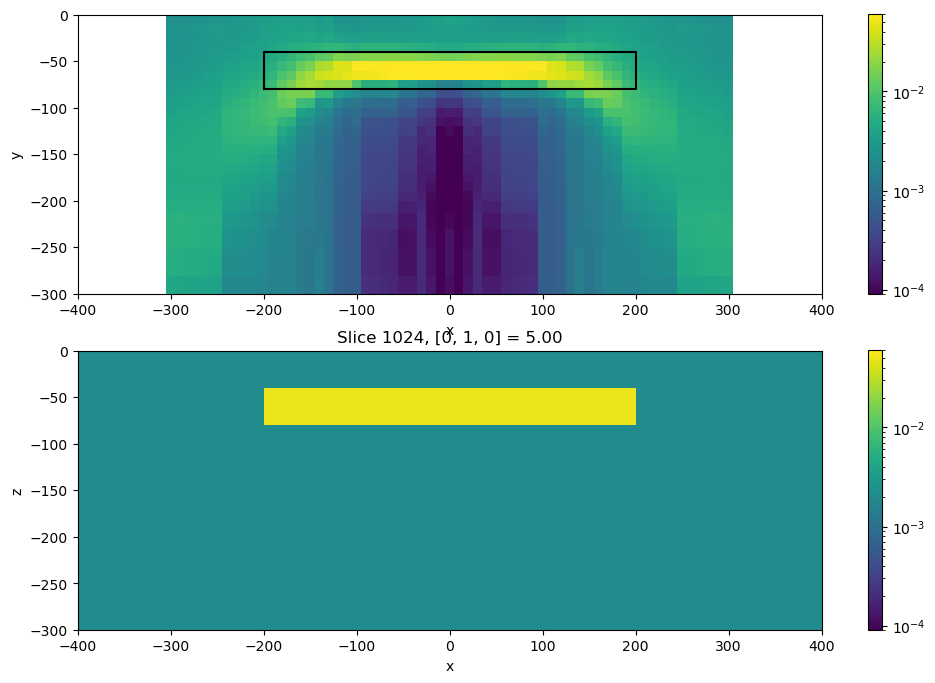

In [855]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

norm = LogNorm(vmin=9e-5, vmax=6e-2)
plt.colorbar(mesh_results.plot_image(
    np.exp(compiled_1d_models),
    # normal="Y", 
    pcolor_opts={"norm":norm},
    ax=ax[0],
    # ind=8
)[0], ax=ax[0])
ax[0].plot(target_outline_x, target_outline_z, color="k", lw=1.5)

plt.colorbar(
    ubc_mesh.plot_slice(
        model, ax=ax[1], pcolor_opts={"norm":norm}, 
        normal="Y",
    )[0], 
    ax=ax[1]
)


for a in ax.flatten():
    a.set_ylim(-300, 0)
    a.set_xlim(np.r_[-1, 1]*400)
    a.set_aspect(1)


In [856]:
dpred_1d = np.zeros((n_times_invert, len(rx_locs)))

for k in inv_dicts.keys():
    ind = int(k)
    
    idict = inv_dicts[k]
    iterations = len(idict)
    dpred_1d[:, ind] = idict[iterations]["dpred"]

    

In [857]:
dpred_1d = dpred_1d.reshape(n_times_invert, len(rx_x), len(rx_y), order="F")

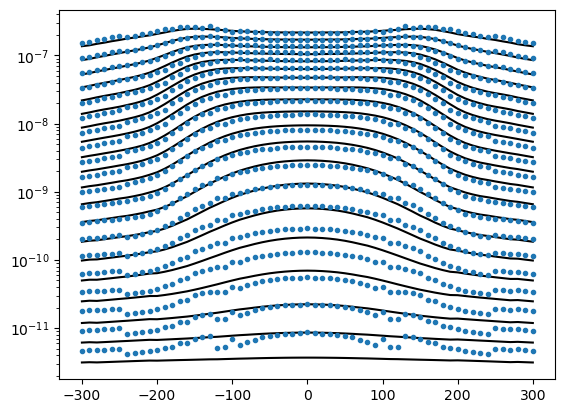

In [858]:
fig, ax = plt.subplots(1, 1)

line_number = 0

ax.semilogy(
    rx_x, -observed_data.dobs.reshape(len(rx_locs[:,0]), 20)[line_number*len(rx_x):(1+line_number)*len(rx_x), :], 
    "k-", ms=3
);

ax.semilogy(rx_x, -dpred_1d[:, :, line_number].T, "C0o", ms=3);

In [859]:
mesh_results_3d=discretize.TensorMesh(
    [mesh_results.h[0], [(10,400)], mesh_results.h[1]], 
    origin = "CCN"
)

In [860]:
mapping_to_3d = maps.Surject2Dto3D(mesh_results_3d)

In [861]:
results3d = mapping_to_3d * compiled_1d_models

In [862]:
# # tmp = compiled_1d_models.reshape(mesh_results.shape_cells[0], mesh_results.shape_cells[1], order="F")
# results3d = np.zeros(mesh_results_3d.n_cells)
# for i in range(mesh_results_3d.shape_cells[1]):
#     inds = mesh_results_3d.cell_centers[:, 1] == mesh_results_3d.cell_centers_y[i]
#     results3d[inds] = compiled_1d_models


(-400.0, 0.0)

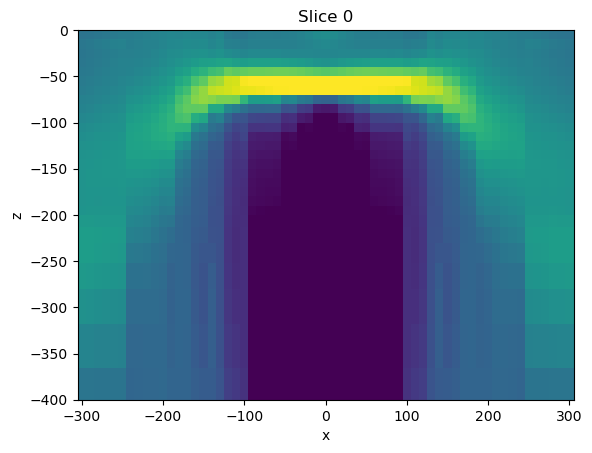

In [863]:
norm = LogNorm(vmin=3e-4, vmax=6e-2)
fig, ax = plt.subplots(1, 1)
mesh_results_3d.plot_slice(
    np.exp(results3d), 
    pcolor_opts={"norm":norm},
    normal="Y",
    ind=0,
    ax=ax
)


ax.set_ylim([-400, 0])


In [864]:
P = discretize.utils.volume_average(mesh_results_3d, ubc_mesh)

In [865]:
interpolated_model = P * results3d
interpolated_model[ubc_mesh.cell_centers[:, 2]>0] = np.log(1e-8)

(-500.0, 100.0)

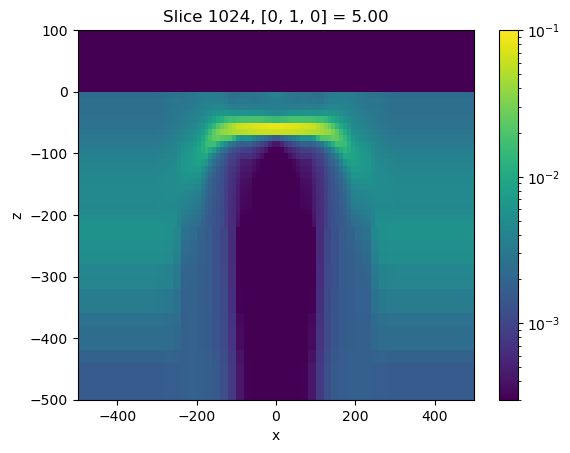

In [866]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(ubc_mesh.plot_slice(
    np.exp(interpolated_model),
    pcolor_opts = {"norm": LogNorm(3e-4, 1e-1)},
    ax=ax,
    normal="y"
)[0], ax=ax)

ax.set_xlim(np.r_[-1, 1]*500)
ax.set_ylim(np.r_[-500, 100])

In [817]:
def load_pre_file(filepath):
    """
    Load a GIF-style .pre file (TDoctree format).

    Parameters
    ----------
    filepath : str
        Path to the .pre-style data file

    Returns
    -------
    dict
        {
            "ignore": float or None,
            "n_trx": int,
            "transmitters": list of {
                "location": list of float,
                "n_recv": int,
                "n_time": int,
                "receivers": list of {
                    "loc": (x, y, z),
                    "time": float,
                    "data": list of float
                }
            }
        }
    """
    with open(filepath, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    i = 0
    ignore_value = None
    transmitters = []

    # Parse IGNORE line if present
    if lines[i].startswith("IGNORE"):
        ignore_value = float(lines[i].split()[1])
        i += 1

    # Parse number of transmitters
    if lines[i].startswith("N_TRX"):
        n_trx = int(lines[i].split()[1])
        i += 1
    else:
        raise ValueError("Missing N_TRX line")

    while i < len(lines):
        if lines[i].startswith("TRX_LOOP"):
            i += 1
            location = list(map(float, lines[i].split()))
            i += 1
            if not lines[i].startswith("N_RECV"):
                raise ValueError("Expected N_RECV")
            n_recv = int(lines[i].split()[1])
            i += 1
            if not lines[i].startswith("N_TIME"):
                raise ValueError("Expected N_TIME")
            n_time = int(lines[i].split()[1])
            i += 1

            receivers = []
            for _ in range(n_recv * n_time):
                parts = lines[i].split()
                x, y, z = map(float, parts[0:3])
                time = float(parts[3])
                data = list(map(float, parts[4:]))
                receivers.append({
                    "loc": (x, y, z),
                    "time": time,
                    "data": data
                })
                i += 1

            transmitters.append({
                "location": location,
                "n_recv": n_recv,
                "n_time": n_time,
                "receivers": receivers
            })
        else:
            i += 1  # Skip unknown or empty lines

    return {
        "ignore": ignore_value,
        "n_trx": len(transmitters),
        "transmitters": transmitters
    }


In [818]:
sim_directory_3d = "3D-sim-1d-results"

In [819]:
discretize.TreeMesh.write_model_UBC(ubc_mesh, f"{sim_directory_3d}/model.con", np.exp(interpolated_model))

In [820]:
# load and plot dpred, 1D inversion dpred, 3D simulation dpred

In [821]:
dpred_from_3d = load_pre_file(f"{sim_directory_3d}/dpred0.txt")
dpred_values = np.zeros((n_times_invert, len(dobs["transmitters"])))

for i in range(len(dpred_from_3d["transmitters"])): 
    for j in range(n_times_invert): 
        dpred_values[j, i] = dpred_from_3d["transmitters"][i]["receivers"][j]["data"][-1]

In [822]:
dpred_values = dpred_values.reshape(n_times_invert, len(rx_x), len(rx_y), order="F")

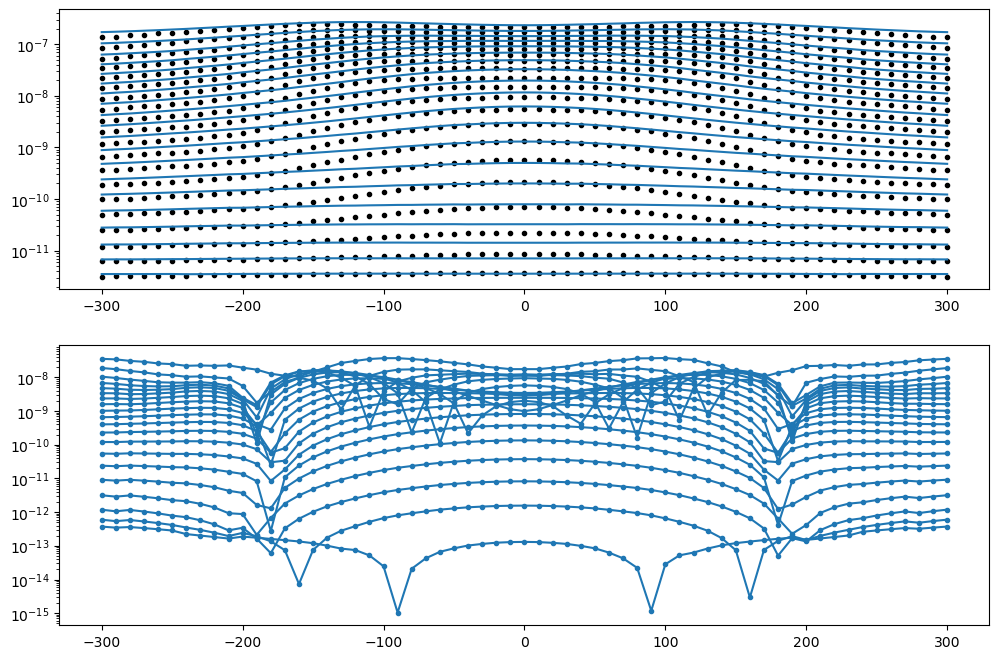

In [828]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

line_number = 0

true_data = -observed_data.dobs.reshape(len(rx_locs[:,0]), 20)[line_number*len(rx_x):(1+line_number)*len(rx_x), :]
ax[0].semilogy(
    rx_x, true_data, 
    "ko", ms=3
);

ax[0].semilogy(rx_x, dpred_values[:, :, line_number].T, "C0-");


ax[1].semilogy(
    rx_x, np.abs(true_data-dpred_values[:, :, line_number].T),
    "C0-o", ms=3
);



In [824]:
# fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# line_number = 4

# true_data = -observed_data.dobs.reshape(len(rx_locs[:,0]), 20)[line_number*len(rx_x):(1+line_number)*len(rx_x), :]
# ax[0].semilogy(
#     rx_x, true_data, 
#     "ko", ms=3
# );

# ax[0].semilogy(rx_x, -dpred_1d[:, :, line_number].T, "C1-");


# ax[1].semilogy(
#     rx_x, np.abs(true_data+dpred_1d[:, :, line_number].T),
#     "C1-o", ms=3
# );




Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e+02  6.06e+02  0.00e+00  6.06e+02    1.69e+02      0              
   1  1.33e+02  3.92e+02  4.00e-01  4.46e+02    1.03e+02      0              
   2  8.89e+01  2.48e+02  1.08e+00  3.44e+02    8.71e+01      0   Skip BFGS  
   3  5.93e+01  1.32e+02  1.94e+00  2.47e+02    6.79e+01      


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e+02  4.05e+02  0.00e+00  4.05e+02    1.85e+02      0              
   1  1.33e+02  2.01e+02  3.60e-01  2.49e+02    8.49e+01      0              
   2  8.89e+01  1.16e+02  7.74e-01  1.85e+02    5.90e+01      0   Skip BFGS  
   3  5.93e+01  6.24e+01  1.20e+00  1.34e+02    4.26e+01      

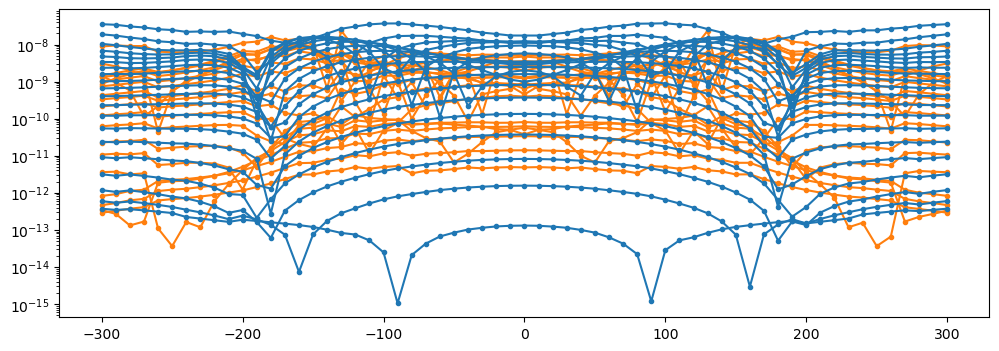


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e+02  9.36e+02  0.00e+00  9.36e+02    1.22e+02      0              
   1  1.33e+02  7.99e+02  2.76e-01  8.36e+02    7.59e+01      0              
   2  8.89e+01  6.73e+02  8.86e-01  7.51e+02    7.81e+01      0   Skip BFGS  
   3  5.93e+01  4.89e+02  2.20e+00  6.19e+02    8.41e+01      

In [825]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.semilogy(
    rx_x, np.abs(true_data+dpred_1d[:, :, line_number].T),
    "C1-o", ms=3
);

ax.semilogy(
    rx_x, np.abs(true_data-dpred_values[:, :, line_number].T),
    "C0-o", ms=3
);

In [221]:
len(rx_locs)

61

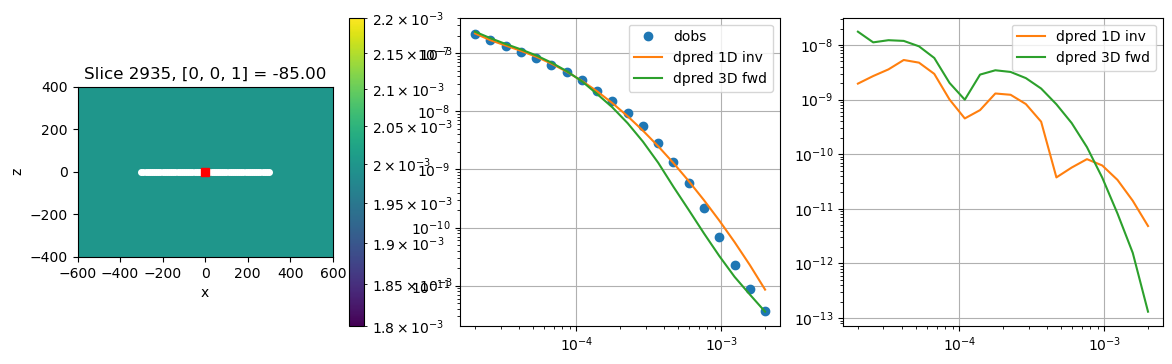

In [829]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

src_ind = 30
source_sounding = source_list[src_ind]

plt.colorbar(
    ubc_mesh.plot_slice(
        model, ax=ax[0], pcolor_opts={"norm":LogNorm()}, 
        normal="Z", ind=2935
    )[0], 
    ax=ax[0]
)

ax[0].set_xlim(600*np.r_[-1, 1])
ax[0].set_ylim(400*np.r_[-1, 1])
ax[0].set_aspect(1)

ax[0].plot(rx_locs[:, 0], rx_locs[:, 1], "wo", ms=4)
ax[0].plot(rx_locs[src_ind, 0], rx_locs[src_ind, 1], "rs", ms=6)


# ax[1].loglog(rx_times, -dpred_halfspace, "k-", ms=4, label="halfspace", alpha=0.2)
ax[1].loglog(rx_times, -observed_data[source_sounding, source_sounding.receiver_list[0]], "C0o", ms=6, label="dobs")
ax[1].loglog(rx_times, -dpred_1d.reshape(20, len(rx_x)*len(rx_y), order="F")[:, src_ind], "C1-", label="dpred 1D inv")
ax[1].loglog(rx_times, dpred_values.reshape(20, len(rx_x)*len(rx_y), order="F")[:, src_ind], "C2-", label="dpred 3D fwd")
ax[1].grid()
ax[1].legend()

true = -observed_data[source_sounding, source_sounding.receiver_list[0]]
# ax[2].loglog(rx_times, , "C0o", ms=6, label="dobs")
ax[2].loglog(rx_times, np.abs(true + dpred_1d.reshape(20, len(rx_x)*len(rx_y), order="F")[:, src_ind]), "C1-", label="dpred 1D inv")
ax[2].loglog(rx_times, np.abs(true-dpred_values.reshape(20, len(rx_x)*len(rx_y), order="F")[:, src_ind]), "C2-", label="dpred 3D fwd")
ax[2].grid()
ax[2].legend()

# ax.legend()

In [236]:
dpred_1d.reshape(20, len(rx_x)*len(rx_y), order="F")[:, src_ind]

array([-1.72027067e-07, -1.11406377e-07, -7.05579592e-08, -4.33821654e-08,
       -2.58012025e-08, -1.48320582e-08, -8.25135840e-09, -4.45530567e-09,
       -2.34632541e-09, -1.21424721e-09, -6.23908978e-10, -3.22191610e-10,
       -1.69060605e-10, -9.06486310e-11, -4.95805481e-11, -2.74628161e-11,
       -1.52743032e-11, -8.47485546e-12, -4.67425894e-12, -2.55992284e-12])